In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import sys
import pandas as pd
import numpy as np
import anndata as ad
from cellxgene_census import download_source_h5ad
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("/")
from src.sparse_autoencoder import SparseAutoencoder

In [248]:
plt.rcParams['axes.labelsize'] = 14  # Axis labels font size
plt.rcParams['axes.titlesize'] = 18  # Title font size
plt.rcParams['legend.fontsize'] = 12  # Legend font size

### Read in SAE Transformed Dataset

In [159]:
sae_adata = ad.read_h5ad("./sae_adata.h5ad")

## Analysis 1:
### Plan
- create a one hot encoding of the meta data
- Compute correlations between individual features and each ohe metadata column for the "dense" SCVI representation and the "sparse" SAE one.
- find feature/cell pairs with extreme correlation for one metadata column and low correlation for the rest.  This suggest monosemanticity.
- Compare the amount of these features in the dense representation vs. the sparse.
- Plot UMAPs of selected features for qualitative inspection.

### One Hot Encode Metadata categories

In [160]:
# cell_type_onehot = pd.get_dummies(sae_adata.obs['cell_type'])
cell_type_onehot = pd.get_dummies(sae_adata.obs[['cell_type','Dataset','disease','donor_id']])
cell_type_onehot.head()

,"cell_type_CD4-positive, alpha-beta cytotoxic T cell","cell_type_CD16-negative, CD56-bright natural killer cell, human",cell_type_IgA plasmablast,cell_type_IgG plasmablast,"cell_type_activated CD4-positive, alpha-beta T cell, human","cell_type_activated CD8-positive, alpha-beta T cell, human","cell_type_central memory CD4-positive, alpha-beta T cell",cell_type_classical monocyte,cell_type_conventional dendritic cell,cell_type_double negative thymocyte,...,donor_id_cov03,donor_id_cov04,donor_id_cov07,donor_id_cov08,donor_id_cov09,donor_id_cov10,donor_id_cov11,donor_id_cov12,donor_id_cov17,donor_id_cov18
Wilk-HIP002.100,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
Wilk-HIP002.1000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Wilk-HIP002.1001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Wilk-HIP002.1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Wilk-HIP002.1003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Compute Correlations

In [161]:
# formate data
f_hidden = sae_adata.obsm['f_non_zero']
z_scvi = sae_adata.X
cell_type_onehot_matrix = cell_type_onehot.values

#compute correlations
f_hidden_correlations = np.corrcoef(f_hidden.T, cell_type_onehot_matrix.T)[:f_hidden.shape[1], f_hidden.shape[1]:]
z_scvi_correlations = np.corrcoef(z_scvi.T, cell_type_onehot_matrix.T)[:z_scvi.shape[1], z_scvi.shape[1]:]

#Convert correlation matrix to DataFrame for easier interpretation
f_hidden_correlation_df = pd.DataFrame(f_hidden_correlations,
                                       index=[f"f_hidden_feature_{i:04d}" for i in range(sae_adata.obsm['f_non_zero'].shape[1])],
                                       columns=cell_type_onehot.columns)

z_scvi_correlation_df = pd.DataFrame(z_scvi_correlations,
                                     index=[f"z_scvi_feature{i:04d}" for i in range(sae_adata.X.shape[1])],
                                     columns=cell_type_onehot.columns)

### Find Features with singular correlations

In [162]:
def get_singularly_correlated_features(correlation_threshold, correlation_df):
    strong_correlations = (correlation_df.abs() > correlation_threshold)
    singular_correlations = strong_correlations.sum(axis=1) == 1
    singularly_correlated_features = correlation_df[singular_correlations]
    return singularly_correlated_features


correlation_threshold = .5
f_singularly_correlated_features = get_singularly_correlated_features(correlation_threshold, f_hidden_correlation_df)
z_singularly_correlated_features = get_singularly_correlated_features(correlation_threshold, z_scvi_correlation_df)

## plot singularly correlated features

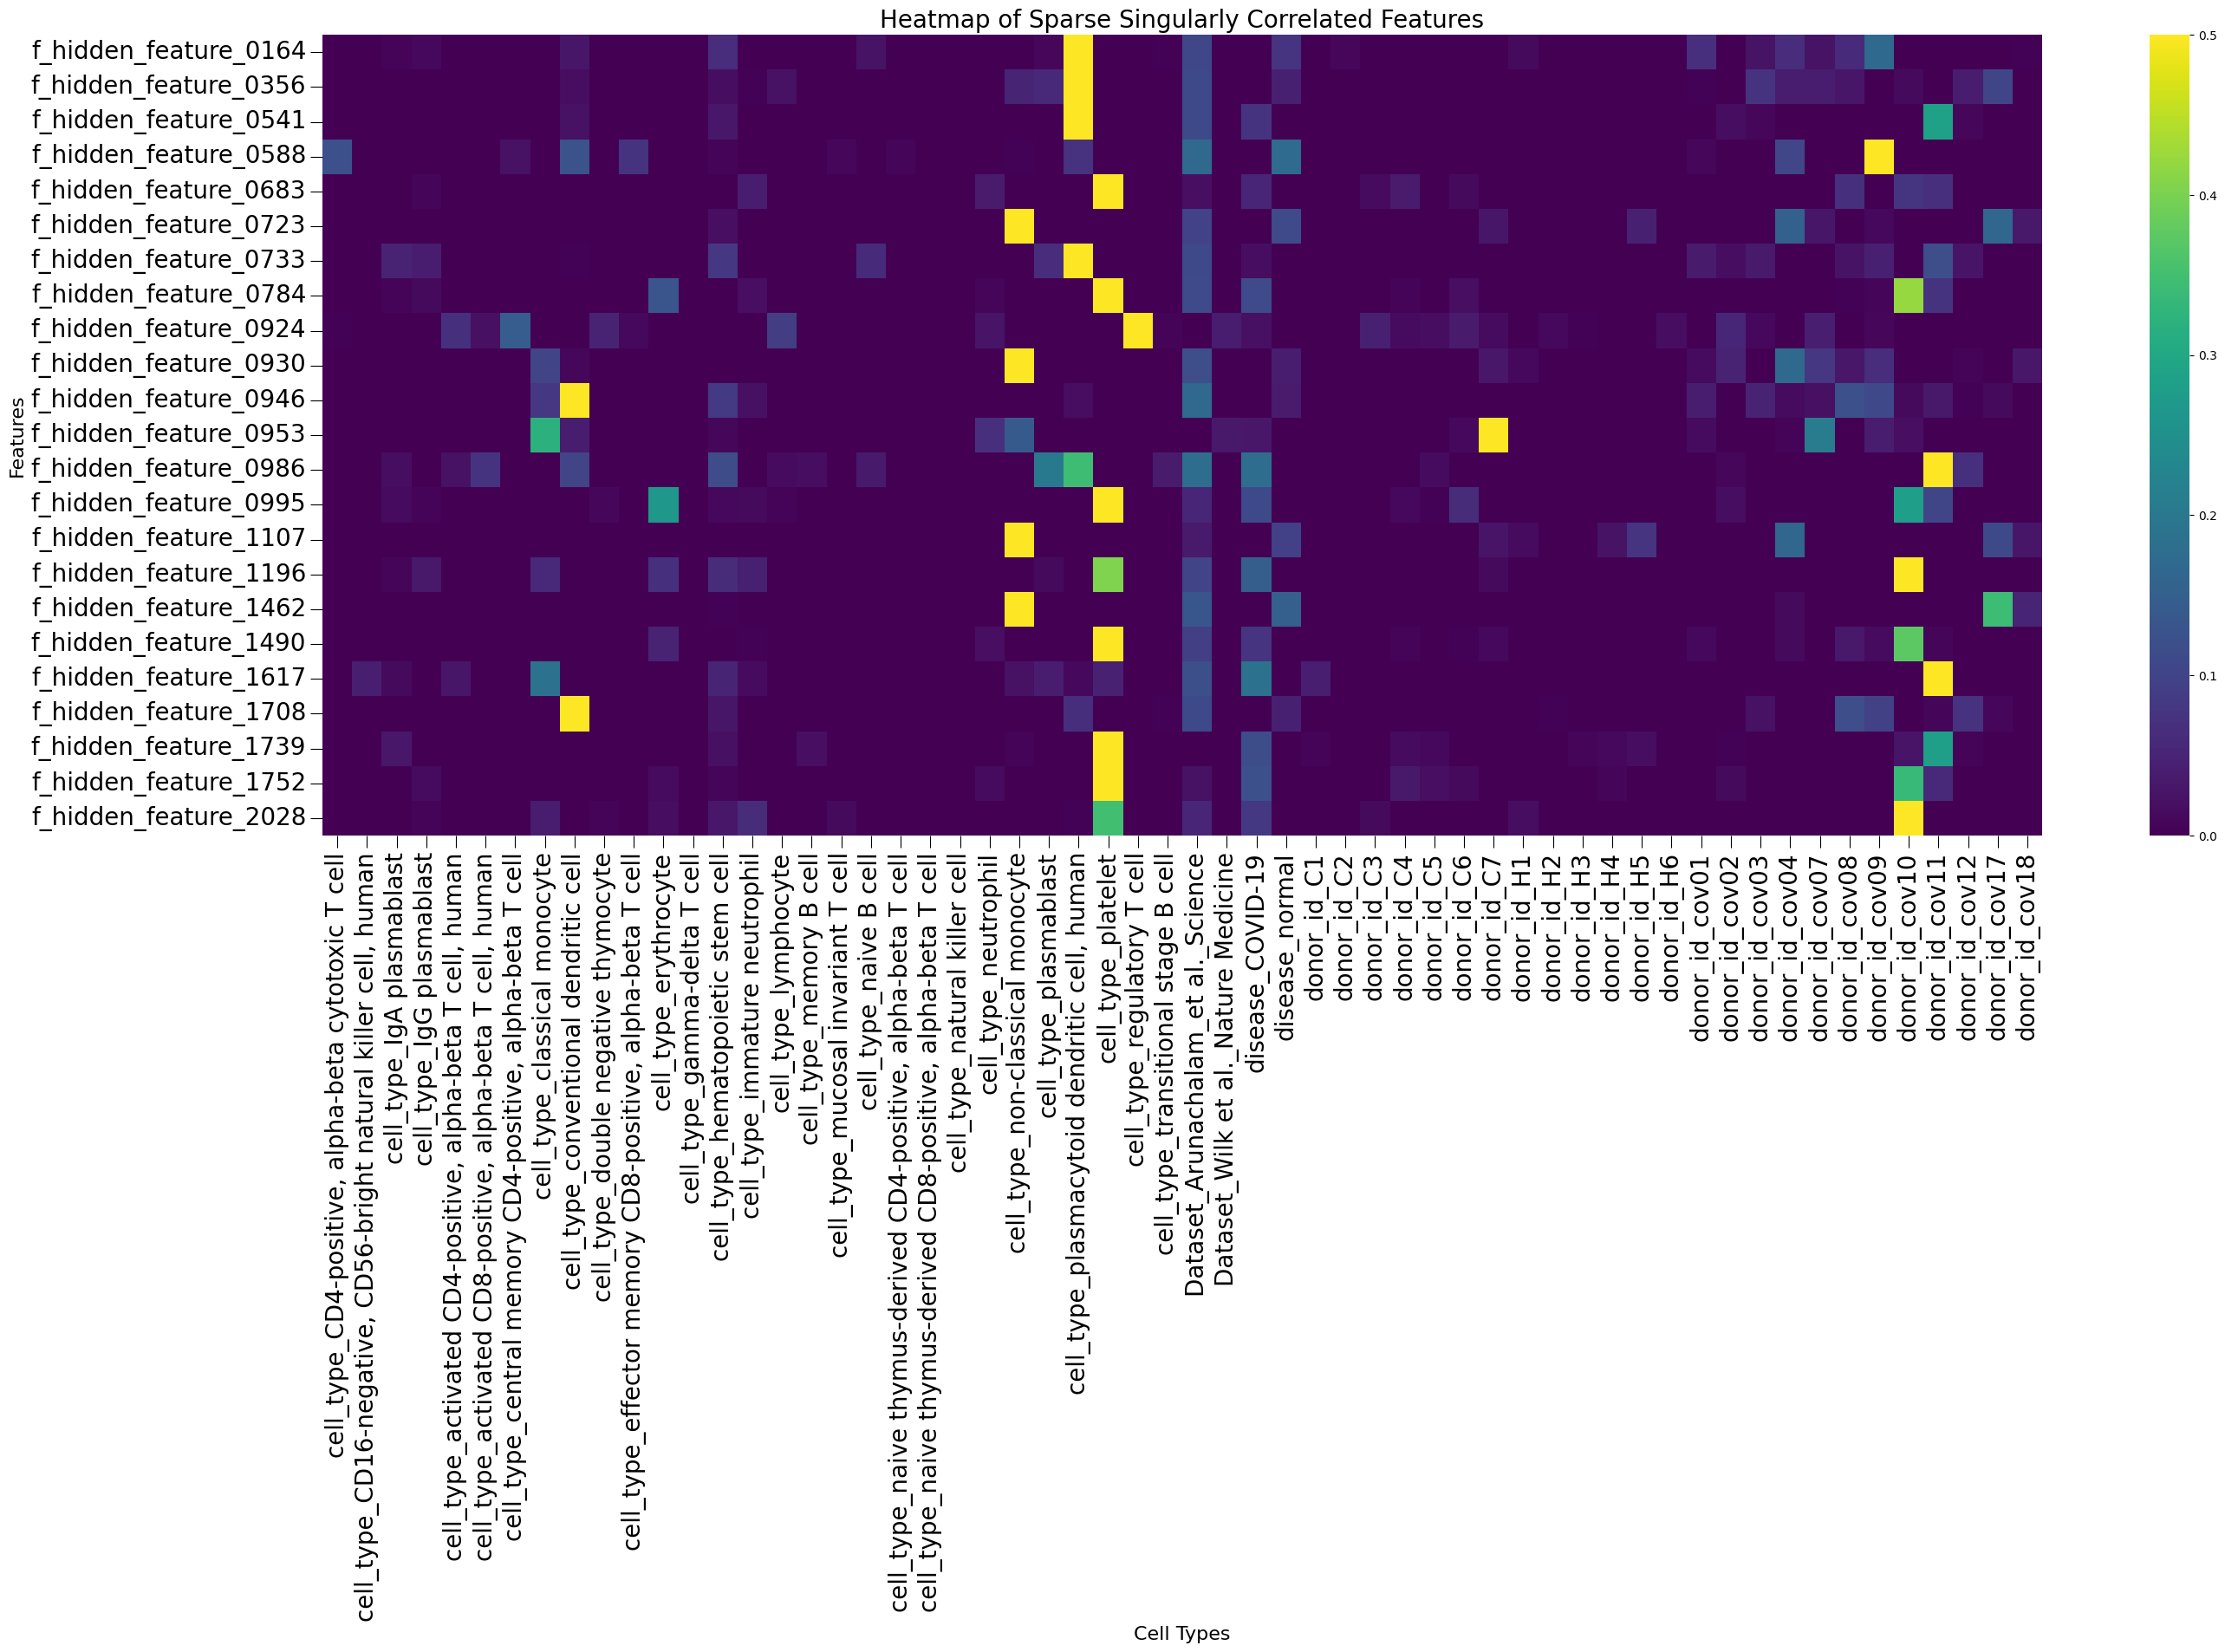

In [256]:
plt.figure(figsize=(32, 12))
sns.heatmap(f_singularly_correlated_features, cmap='viridis', annot=False, vmin=0, vmax=0.5)

# Customize tick parameters
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().tick_params(axis='x', length=10)
plt.gca().tick_params(axis='y', length=10)

# Set axis labels and title
plt.xlabel('Cell Types', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.title('Heatmap of Sparse Singularly Correlated Features', fontsize=20)

# Show the plot
plt.show()

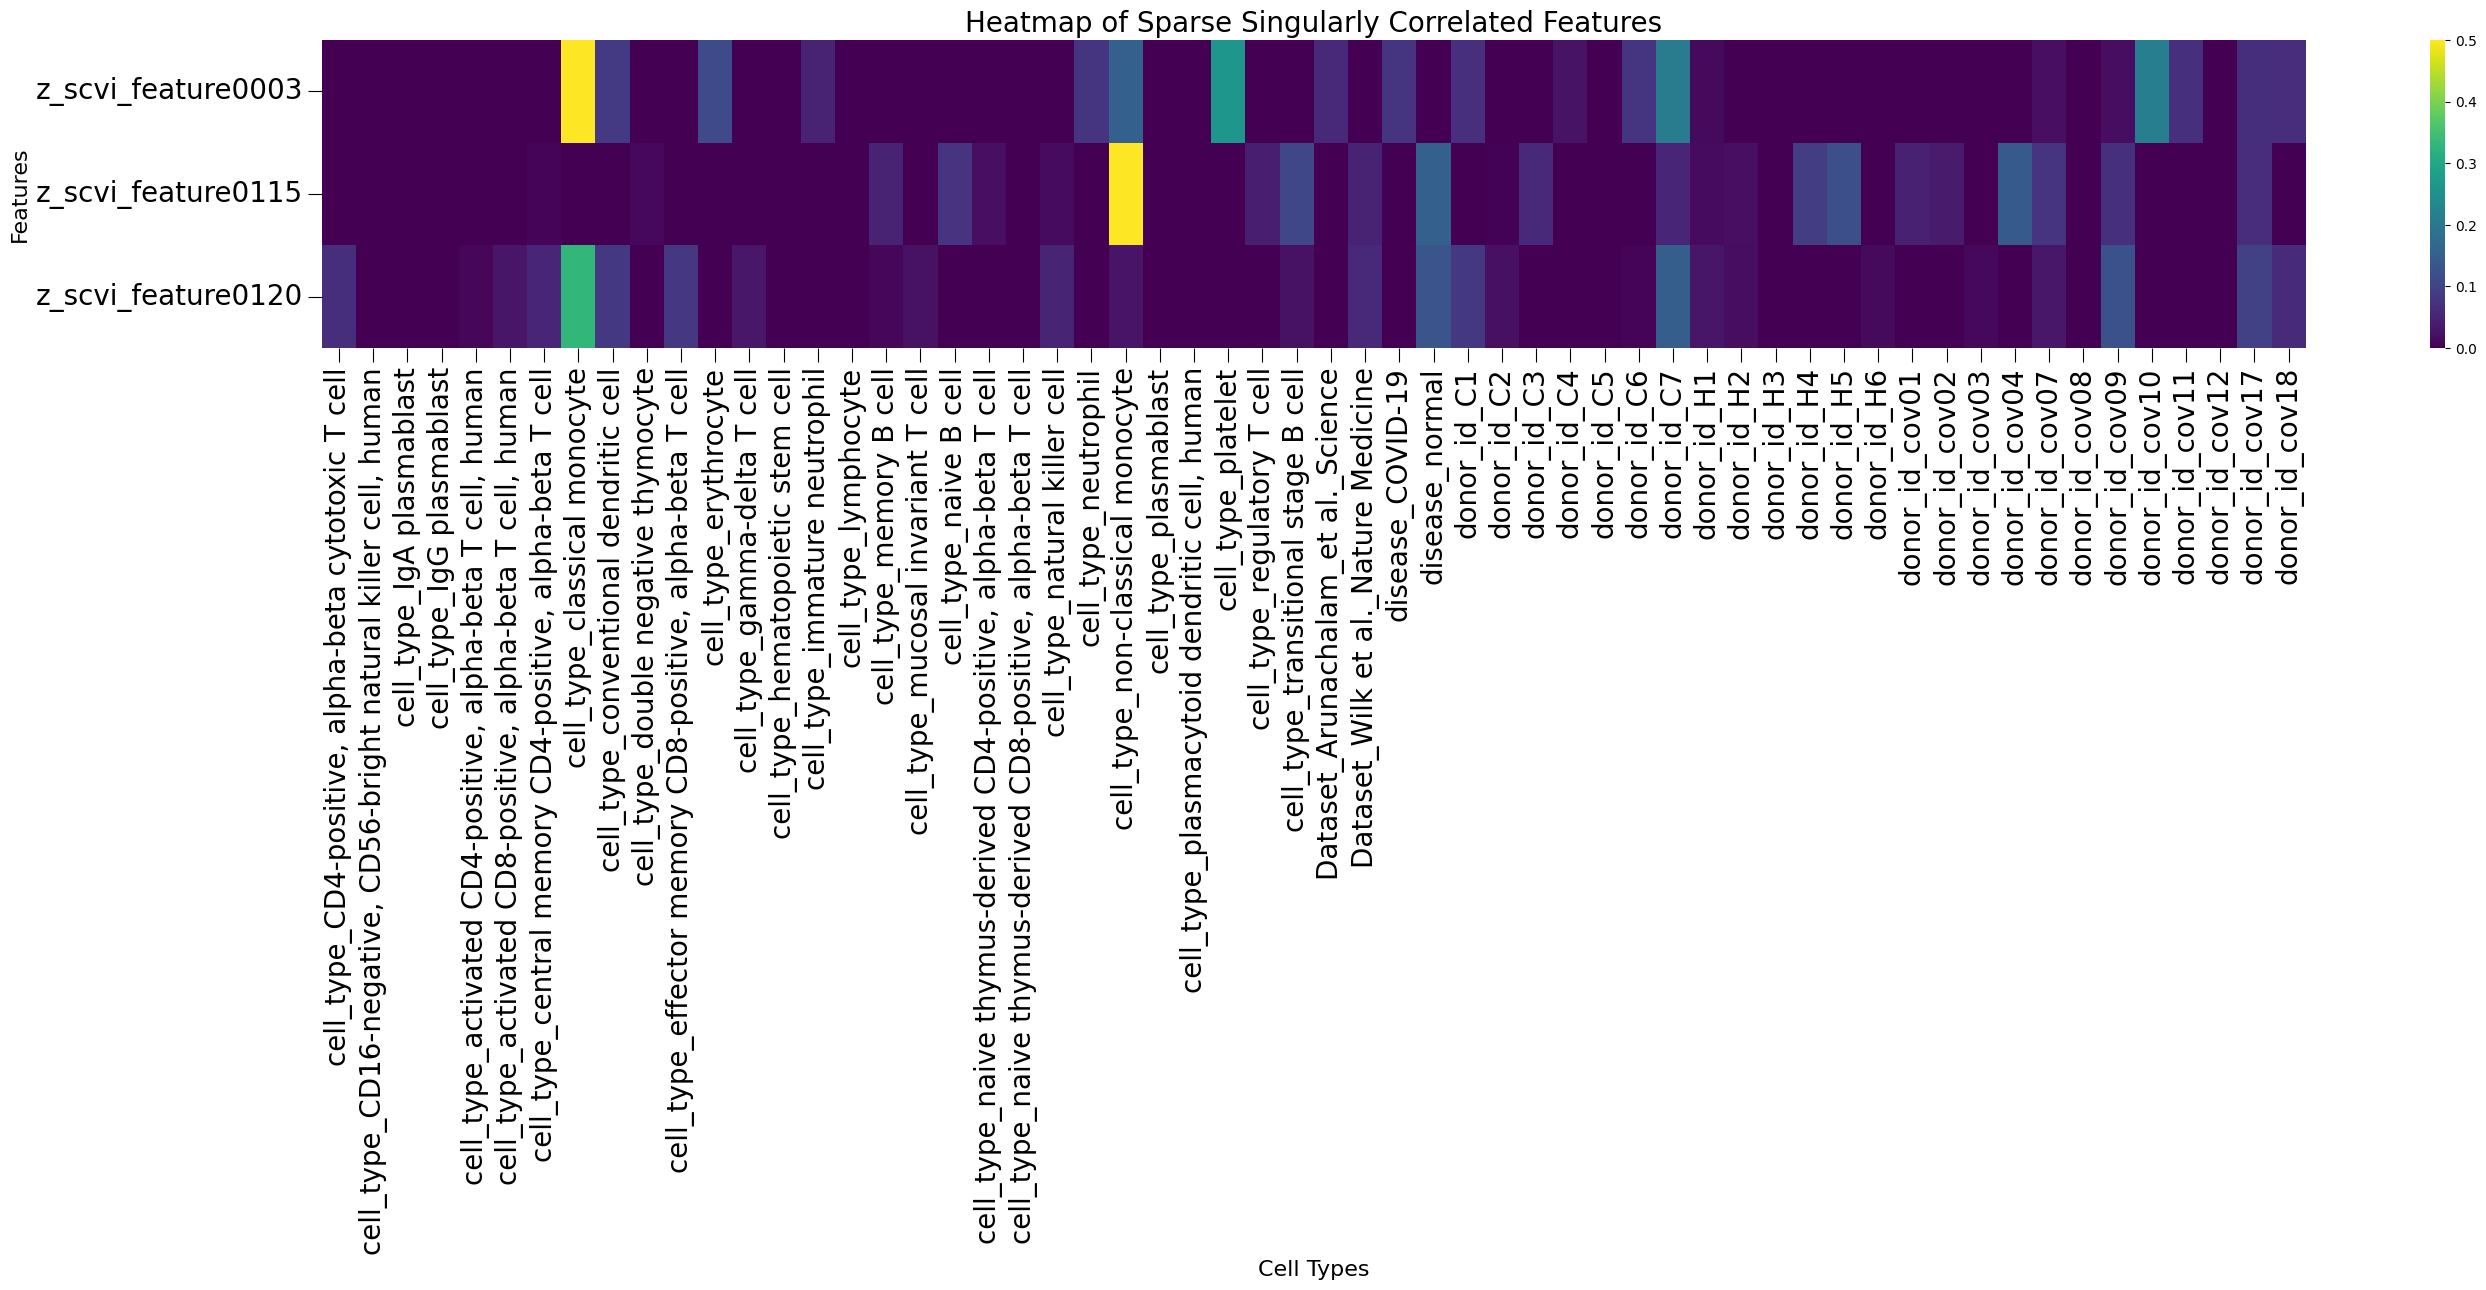

In [258]:
plt.figure(figsize=(32, 4))
sns.heatmap(z_singularly_correlated_features, cmap='viridis', annot=False, vmin=0, vmax=0.5)

# Customize tick parameters
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().tick_params(axis='x', length=10)
plt.gca().tick_params(axis='y', length=10)

# Set axis labels and title
plt.xlabel('Cell Types', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.title('Heatmap of Sparse Singularly Correlated Features', fontsize=20)

# Show the plot
plt.show()